### Super Resolution

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai.vision.gan import *

In [3]:
from PIL import ImageDraw

In [4]:
BS = 4
SIZE = (512, 360)

In [5]:
# def resize(img, targ_sz, use_min=False):
#     w,h = img.size
#     min_sz = (min if use_min else max)(w,h)
#     ratio = targ_sz/min_sz
#     return int(w*ratio),int(h*ratio)

In [6]:
# class Crappifier():
#     def __init__(self, path_lr, path_hr):
#         self.path_lr = path_lr
#         self.path_hr = path_hr
        
#     def __call__(self, fn):
#         dest = self.path_lr/fn.relative_to(self.path_hr)
#         dest.parent.mkdir(parents=True, exist_ok=True)
#         img = Image.open(fn)
#         targ_sz = resize(img, 144, use_min=True)
#         img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
#         w,h = img.size
#         q = random.randint(10,70)
#         img.save(dest, quality=q)

In [7]:
data_path = Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/Walkwithfastai Data')

In [8]:
path_hr = data_path/'HiRes'
path_lr = data_path/'LowRes'

In [9]:
items = get_image_files(path_hr)

In [10]:
#parallel(Crappifier(path_lr, path_hr), items)

In [11]:
bad_im = get_image_files(path_lr)

In [12]:
im1 = PILImage.create(items[0])
im2 = PILImage.create(bad_im[0])

<AxesSubplot:>

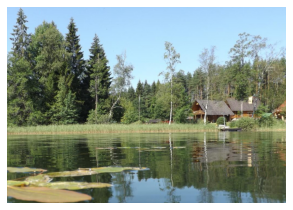

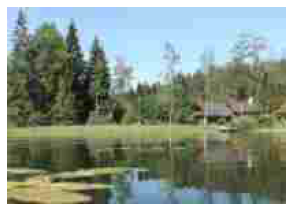

In [13]:
im1.show(); im2.show(figsize=(5,5))

In [14]:
def get_dls(bs:int, size:int):
    dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                       get_items=get_image_files,
                       get_y=lambda x: path_hr/x.name,
                       splitter=RandomSplitter(),
                       item_tfms=Resize(size),
                       batch_tfms=[*aug_transforms(max_zoom=2.),
                                   Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(path_lr, bs=bs, path=data_path, num_workers=0)
    dls.c = 3
    return dls

In [15]:
dls_gen=get_dls(BS, SIZE)

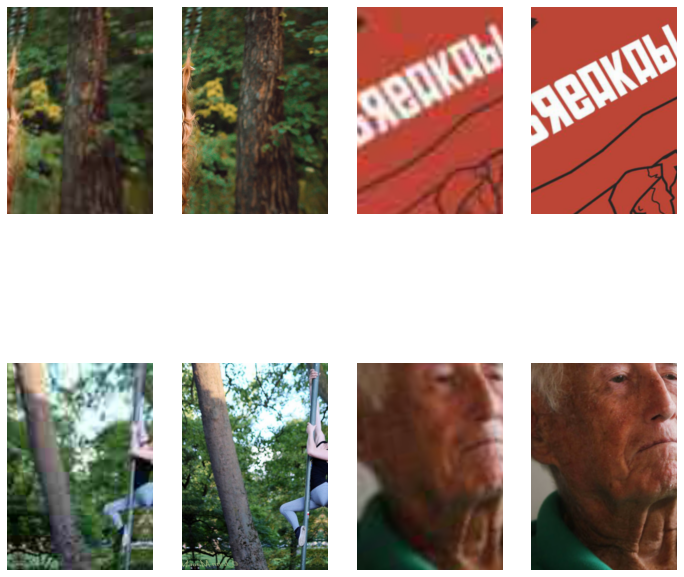

In [16]:
dls_gen.show_batch(max_n=4, figsize=(12,12))

In [17]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [18]:
bbone = resnet34
def create_gen_learner():
    return unet_learner(dls_gen, bbone, loss_func=loss_gen,
                        blur=True, norm_type=NormType.Weight, self_attention=True, y_range=y_range)

In [19]:
learn_gen = create_gen_learner()

In [20]:
learn_gen.fit_one_cycle(5, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time
0,0.094140,0.103783,04:51
1,0.089009,0.099523,04:24
2,0.087431,0.097990,04:24
3,0.078698,0.097299,04:24
4,0.080746,0.095111,04:24


In [21]:
learn_gen.unfreeze()

In [22]:
learn_gen.fit_one_cycle(5, slice(1e-6, 1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.085791,0.097625,04:35
1,0.080459,0.093801,04:35
2,0.081506,0.091619,04:36
3,0.080290,0.092199,04:35
4,0.079410,0.092942,04:34


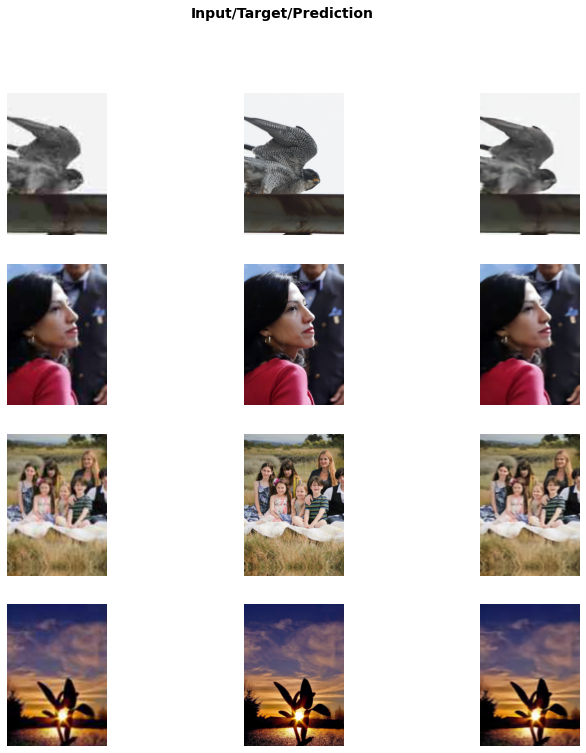

In [23]:
learn_gen.show_results(max_n=4, figsize=(12,12))

In [24]:
learn_gen.save(data_path/'gen-pre2')

Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/Walkwithfastai Data/gen-pre2.pth')

In [25]:
name_gen = 'image_gen'
path_gen = data_path/name_gen

In [26]:
#path_gen.mkdir(exist_ok=True)

In [27]:
def save_preds(dl, learn):
    names = dl.dataset.items
    
    preds,_= learn.get_preds(dl=dl)
    for i,pred in enumerate(preds):
        dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
        arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
        Image.fromarray(arr).save(path_gen/names[i].name)

In [28]:
dl = dls_gen.train.new(shuffle=False, drop_last=False, after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [29]:
preds,_=learn_gen.get_preds(dl=dl)

In [30]:
# preds[0].shape

In [31]:
# preds[0][None].shape

In [32]:
dec = dl.after_batch.decode((TensorImage(preds[0][None]),))[0][0]

In [33]:
arr = dec.numpy().transpose(1,2,0)

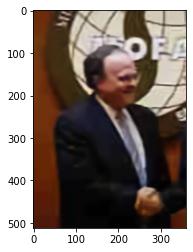

In [34]:
plt.imshow(arr.astype(np.uint8))

In [ ]:
save_preds(dl, learn_gen)

In [ ]:
path_gen

In [ ]:
name_gen

In [ ]:
path_g = get_image_files(data_path/name_gen)
path_i = get_image_files(data_path/'HiRes')
fnames = path_g + path_i

In [ ]:
fnames[0]

In [ ]:
def get_crit_dls(fnames, bs:int, size:int):
    splits = RandomSplitter(0.1)(fnames)
    dsrc = Datasets(fnames, tfms=[[PILImage.create], [parent_label, Categorize]], splits=splits)
    tfms = [ToTensor(), Resize(size)]
    gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
    return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms, num_workers=0)

In [ ]:
dls_crit = get_crit_dls(fnames, bs=BS, size=SIZE)

In [ ]:
dls_crit.show_batch()
plt.show()

In [ ]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [ ]:
def create_crit_learner(dls, metrics):
    return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_crit)

In [ ]:
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)

In [ ]:
learn_crit.fit_one_cycle(10, 1e-3, wd=wd)

In [ ]:
learn_crit.save(data_path/'critic-pre2')

In [ ]:
ls_crit = get_crit_dls(fnames, bs=BS, size=SIZE)

In [ ]:
learn_crit = create_crit_learner(dls_crit,metrics=None).load(data_path/'critic-pre2')

In [ ]:
learn_gen = create_gen_learner().load(data_path/'gen-pre2')

In [ ]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50), show_img=False, 
                                 switcher=FixedGANSwitcher(n_crit=1, n_gen=1),
                   opt_func=partial(Adam, mom=0.), cbs=GANDiscriminativeLR(mult_lr=5.0))


In [ ]:
lr = 1e-4

In [ ]:
learn.fit(10, lr, wd=wd)

In [ ]:
learn.show_results()